
# **MAPA DE `ANOMALIA DE TEMPERATURA` COM DADOS DO ERA-5 VIA PROTOCOLO OPENDAP**
---

- ERA-5 `MENSAL`
1. Informação sobre os dados: http://apdrc.soest.hawaii.edu/dods/public_data/Reanalysis_Data/ERA5/monthly_2d/Surface.info

2. URL dos dados: http://apdrc.soest.hawaii.edu:80/dods/public_data/Reanalysis_Data/ERA5/monthly_2d/Surface


---

- Código realizado por: Enrique V. Mattos -- 16/04/2024 - enrique@unifei.edu.br


---

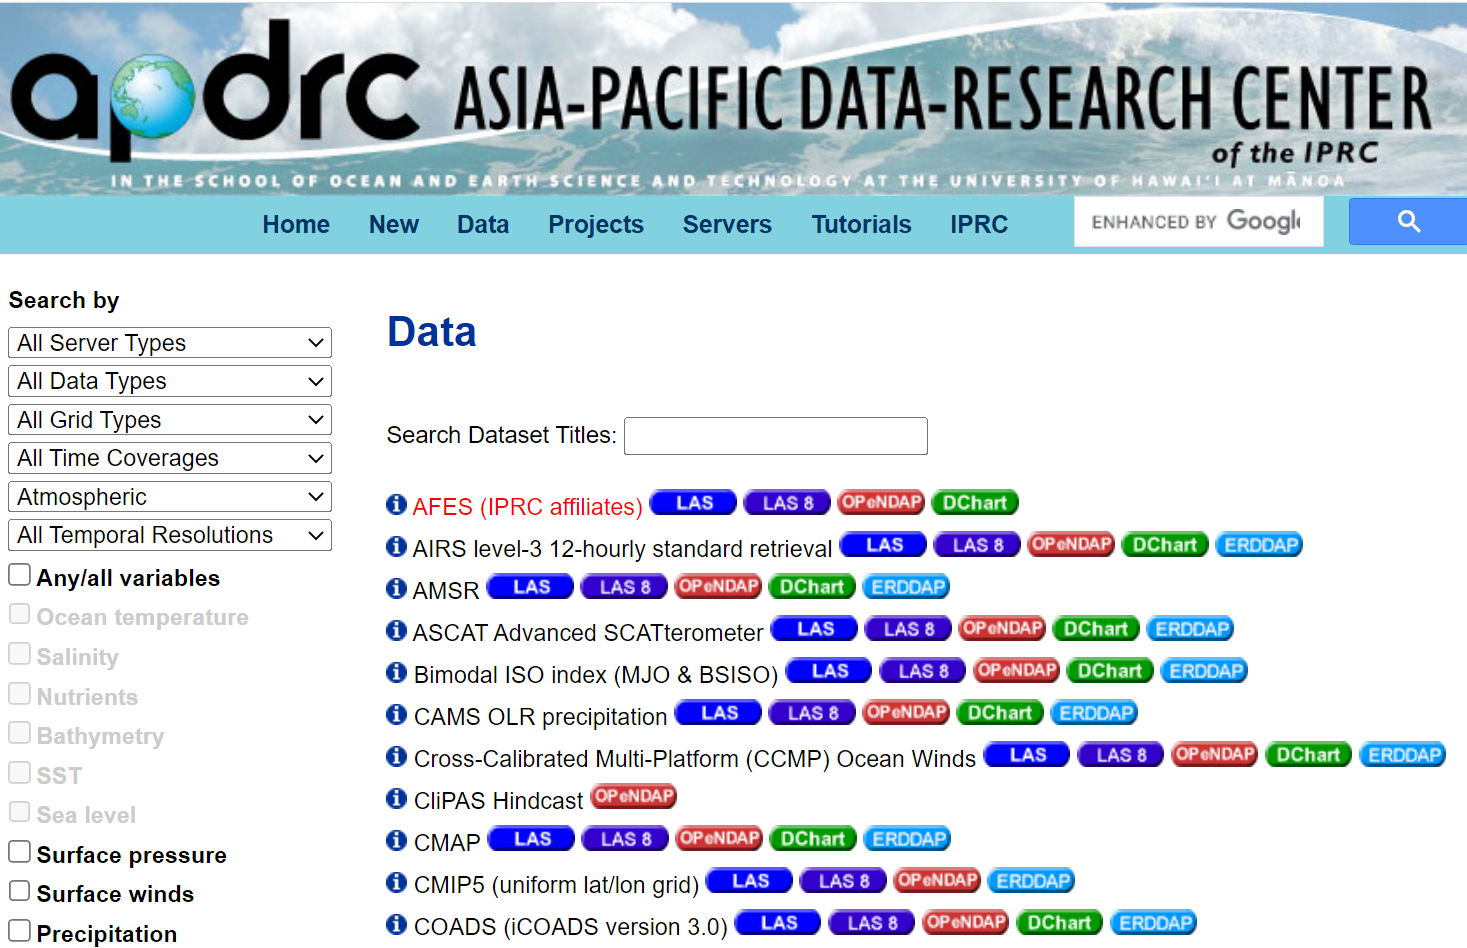

# **1° Passo:** Instalando bibliotecas

In [1]:
# Instalando matplotlib, proplot e numpy
!pip install -q matplotlib==3.4.3
!pip install -q proplot==0.9.7
!pip install -q numpy==1.24.3

# Instalando salem
!pip install -q salem==0.3.9

# Instalando rasterio, pyproj e geopandas
!pip install -q rasterio pyproj geopandas

# Instalando cartopy
!pip uninstall shapely --yes
!pip install -q shapely cartopy==0.21.1 --no-binary shapely --no-binary cartopy

Found existing installation: shapely 2.0.3
Uninstalling shapely-2.0.3:
  Successfully uninstalled shapely-2.0.3


- Chegando aqui, será necessário fazer a `Reinicialização do Ambiente de Execução`. Para isto, você deverá acessar `Ambiente de execução`, localizado na barra de ferramentas e clicar em `Reiniciar Sessão`. Como indicado na imagem abaixo.

- Em seguida você deverá rodar novamente a célula anterior de instalações, de forma que as bibliotecas sejam instaladas novamente.

- Isso é necessário tanto para poder usar sem problemas o `Proplot` quanto o `CartoPy` na nossa sessão do Colab. Então a partir desse ponto não teremos mais que nos preocupar com a preparação do ambiente virtual.

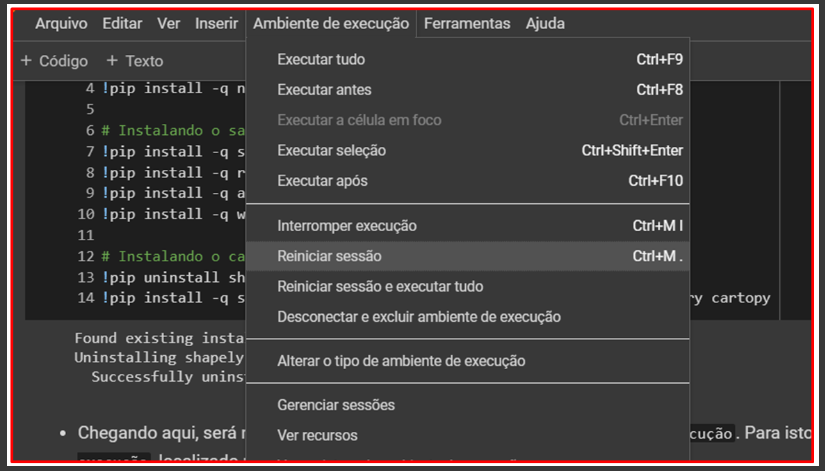

# **2° Passo:** Importando bibliotecas

In [2]:
import proplot as pplt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import xarray as xr
import matplotlib.pyplot as plt
import time
import salem

# vamos ignorar avisos
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/proplot/__init__.py:71: ProplotWarning: Rebuilding font cache. This usually happens after installing or updating proplot.
  register_fonts(default=True)


# **PARTE 1)**:  LEITURA DOS DADOS E PROCESSAMENTO

##Define `ano` e `mês`

In [18]:
ano, mes = '2023', '12'

##Leitura dos dados

In [19]:
%%time

# nome do mês
nome_mes =  ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']

# limites do Brasil
lonmin, lonmax, latmin, latmax = -75.0, -33.0, -35.0, 7.0

# link dos dados
url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/Reanalysis_Data/'

# carrega os dados
t2m_mensal = xr.open_dataset(url + 'ERA5/monthly_2d/Surface')

# transforma as longitudes de 0/360 para -180/+180
t2m_mensal.coords['lon'] = ((t2m_mensal.coords['lon'] + 180) % 360) - 180
t2m_mensal = t2m_mensal.sortby(t2m_mensal.lon)

# seleciona os dados para o Brasil
t2m_mensal_brasil = t2m_mensal.sel(lon=slice(lonmin,lonmax), lat=slice(latmin,latmax)) #.sel(time=slice('1990-01-01','2024-12-01'))

# mostra os dados
t2m_mensal_brasil

CPU times: user 51.7 ms, sys: 6.65 ms, total: 58.3 ms
Wall time: 1.15 s


<xarray.Dataset>
Dimensions:  (time: 1011, lat: 169, lon: 169)
Coordinates:
  * time     (time) datetime64[ns] 1940-01-01 1940-02-01 ... 2024-03-01
  * lat      (lat) float64 -35.0 -34.75 -34.5 -34.25 -34.0 ... 6.25 6.5 6.75 7.0
  * lon      (lon) float64 -75.0 -74.75 -74.5 -74.25 ... -33.5 -33.25 -33.0
Data variables:
    u10      (time, lat, lon) float32 ...
    v10      (time, lat, lon) float32 ...
    t2m      (time, lat, lon) float32 ...
    iews     (time, lat, lon) float32 ...
    inss     (time, lat, lon) float32 ...
    msl      (time, lat, lon) float32 ...
    skt      (time, lat, lon) float32 ...
    sp       (time, lat, lon) float32 ...
    sst      (time, lat, lon) float32 ...
    tp       (time, lat, lon) float32 ...
Attributes:
    title:          ERA5 monthly averaged reanalysis single level variables
    Conventions:    COARDS\nGrADS
    dataType:       Grid
    documentation:  http://apdrc.soest.hawaii.edu/datadoc/ecmwf_ERA5.php
    history:        Tue Apr 09 08:12:34 HST 2024 : imported by GrADS Data Ser...

##Calcula anomalia

In [20]:
%%time

# leitura do shapefile do Brasil
shapefile_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/brasil/BRAZIL.shp')

# transforma de Kelvim para Celsius
t2m_mensal_brasil = t2m_mensal_brasil['t2m'] - 275.15

# calculando a CLIMATOLOGIA
climatologia = t2m_mensal_brasil.sel(time=slice('1990-01-01','2020-12-31')).groupby("time.month").mean("time")

# calculando a ANOMALIA
anomalia = t2m_mensal_brasil.sel(time=slice(f'{ano}-{mes}',f'{ano}-{mes}')).groupby("time.month") - climatologia

# recorta o dado para região
anomalia = anomalia.salem.roi(shape=shapefile_brasil)

# mostra os dados
anomalia

CPU times: user 2.28 s, sys: 364 ms, total: 2.64 s
Wall time: 25.3 s


<xarray.DataArray 't2m' (time: 1, lat: 169, lon: 169)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2023-12-01
  * lat      (lat) float64 -35.0 -34.75 -34.5 -34.25 -34.0 ... 6.25 6.5 6.75 7.0
  * lon      (lon) float64 -75.0 -74.75 -74.5 -74.25 ... -33.5 -33.25 -33.0
    month    (time) int64 12
Attributes:
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

# **PARTE 2)**:  MAPA DE `ANOMALIA` PARA UM DETERMINADO MÊS

CPU times: user 5.8 s, sys: 573 ms, total: 6.38 s
Wall time: 6.28 s


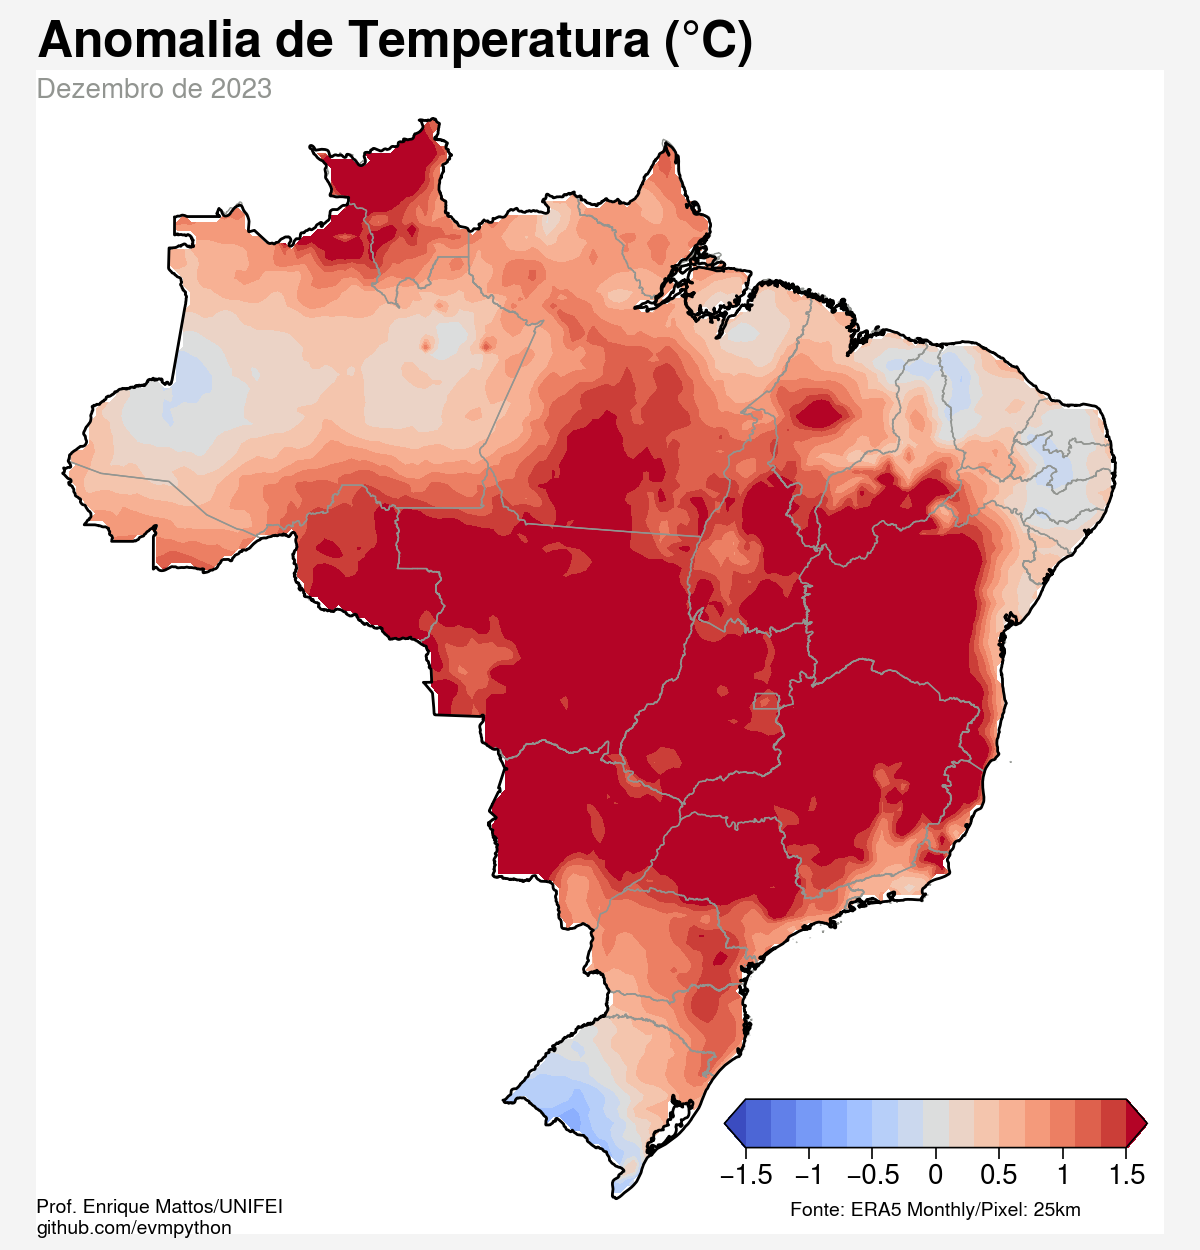

In [21]:
%%time

#========================================================================================================================#
#                                           PLOTA FIGURA
#========================================================================================================================#
# cria a moldura da figura
fig, ax = pplt.subplots(axwidth=6, tight=True, proj='pcarree')

# define formato da figura
ax.format(coast=False, borders=False, innerborders=False,
          labels=False, latlines=5, lonlines=10,
          latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
          title=f'Anomalia de Temperatura ($\degree$C)',
          titleloc='l',
          titleweight='bold',
          titlecolor='black',
          small='20px', large='25px',
          linewidth=0, grid=False)

# plota subtítulo
ax.text(lonmin, latmax-1.0, f'{nome_mes[int(mes)-1]} de {ano}', color='grey', fontsize=10)

# plota mapa
# configuração da barra de cores: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.colorbar.html
map1 = ax.contourf(anomalia['lon'],
                   anomalia['lat'],
                   anomalia[0,:,:],
                   extend='both',
                   cmap='coolwarm',
                   vmin=-1.5, vmax=1.5,
                   levels=pplt.arange(-1.5, 1.5, 0.2),
                   colorbar='best',
                   colorbar_kw={'label': 'Fonte: ERA5 Monthly/Pixel: 25km',
                                'length': 18,
                                'frameon': False,
                                'ticklabelsize': 10,
                                'labelsize': 7,
                                'width': 2,
                                'ticks': 0.5})

# plota contorno dos Estados
estados_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/estados_do_brasil/BR_UF_2019.shp')
estados_brasil.plot(edgecolor='gray', facecolor='none', linewidth=0.5, alpha=1, ax=ax)

# plota contorno do Brasil
contorno_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/brasil/BRAZIL.shp')
contorno_brasil.plot(edgecolor='black', facecolor='none', linewidth=1.0, alpha=1, ax=ax)

# informação na figura
ax.annotate('Prof. Enrique Mattos/UNIFEI\ngithub.com/evmpython', xy=(lonmin,latmin), fontsize=7, color='black')

# salva figura
fig.save(f'Fig_1_ERA5_t2m_anomalia_{ano}_{mes}.png', dpi=300)

# **PARTE 3)**:  MAPA DE `TEMPERATURA` E `ANOMALIA` PARA UM DETERMINADO MÊS

In [22]:
t2m_mensal_brasil

<xarray.DataArray 't2m' (time: 1011, lat: 169, lon: 169)>
array([[[14.756561, 14.588593, 14.444061, ..., 16.147186, 16.14914 ,
         16.158905],
        [14.834686, 14.682343, 14.567108, ..., 16.313202, 16.315155,
         16.33078 ],
        [14.903046, 14.76828 , 14.660858, ..., 16.465546, 16.473358,
         16.490936],
        ...,
        [16.291718, 18.567108, 21.82492 , ..., 23.660858, 23.66867 ,
         23.684296],
        [16.127655, 18.52414 , 21.596405, ..., 23.641327, 23.639374,
         23.64914 ],
        [16.973358, 18.756561, 21.176483, ..., 23.608124, 23.604218,
         23.592499]],

       [[15.082825, 14.950012, 14.864075, ..., 15.934387, 15.912903,
         15.901184],
        [15.166809, 15.073059, 15.000793, ..., 16.133606, 16.114075,
         16.100403],
        [15.264465, 15.182434, 15.106262, ..., 16.321106, 16.303528,
         16.289856],
...
        [20.633331, 23.5513  , 27.719269, ..., 24.631378, 24.609894,
         24.600128],
        [20.229034, 23.20169 , 27.023956, ..., 24.580597, 24.549347,
         24.537628],
        [20.953644, 23.084503, 26.023956, ..., 24.529816, 24.49466 ,
         24.469269]],

       [[14.836761, 14.590668, 14.305511, ..., 18.272308, 18.293793,
         18.282074],
        [14.985199, 14.645355, 14.358246, ..., 18.44809 , 18.469574,
         18.493011],
        [15.12973 , 14.750824, 14.389496, ..., 18.678558, 18.688324,
         18.694183],
        ...,
        [21.46762 , 24.641449, 29.133636, ..., 24.768402, 24.784027,
         24.809418],
        [21.059418, 24.319183, 28.383636, ..., 24.647308, 24.659027,
         24.684418],
        [21.809418, 24.139496, 27.116058, ..., 24.537933, 24.551605,
         24.565277]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1940-01-01 1940-02-01 ... 2024-03-01
  * lat      (lat) float64 -35.0 -34.75 -34.5 -34.25 -34.0 ... 6.25 6.5 6.75 7.0
  * lon      (lon) float64 -75.0 -74.75 -74.5 -74.25 ... -33.5 -33.25 -33.0

In [23]:
t2m_mensal_brasil.loc['2023-08-01']

<xarray.DataArray 't2m' (lat: 169, lon: 169)>
array([[10.714386 , 10.792511 , 10.813995 , ..., 12.603058 , 12.583527 ,
        12.569855 ],
       [10.874542 , 10.911652 , 10.9565735, ..., 12.837433 , 12.802277 ,
        12.782745 ],
       [11.0503235, 11.063995 , 11.062042 , ..., 13.140167 , 13.073761 ,
        13.021027 ],
       ...,
       [21.358917 , 23.901886 , 28.103058 , ..., 24.880402 , 24.864777 ,
        24.858917 ],
       [20.970245 , 23.571808 , 27.214386 , ..., 24.888214 , 24.868683 ,
        24.86087  ],
       [21.581573 , 23.433136 , 26.001495 , ..., 24.874542 , 24.86087  ,
        24.839386 ]], dtype=float32)
Coordinates:
    time     datetime64[ns] 2023-08-01
  * lat      (lat) float64 -35.0 -34.75 -34.5 -34.25 -34.0 ... 6.25 6.5 6.75 7.0
  * lon      (lon) float64 -75.0 -74.75 -74.5 -74.25 ... -33.5 -33.25 -33.0

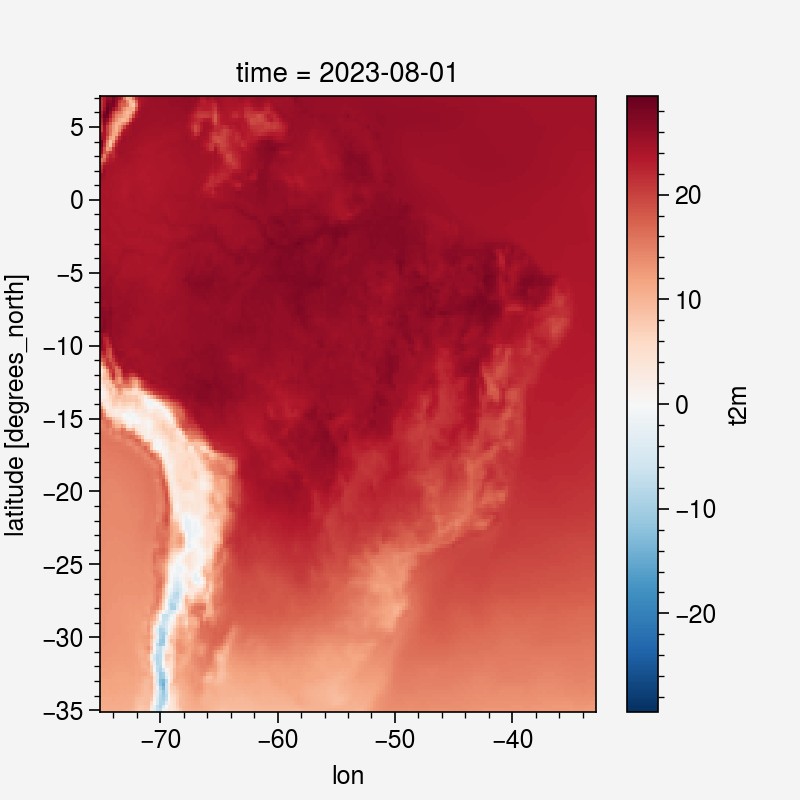

In [24]:
t2m_mensal_brasil.loc['2023-08-01'].plot()

In [25]:
anomalia

<xarray.DataArray 't2m' (time: 1, lat: 169, lon: 169)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2023-12-01
  * lat      (lat) float64 -35.0 -34.75 -34.5 -34.25 -34.0 ... 6.25 6.5 6.75 7.0
  * lon      (lon) float64 -75.0 -74.75 -74.5 -74.25 ... -33.5 -33.25 -33.0
    month    (time) int64 12
Attributes:
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

CPU times: user 12.3 s, sys: 1.57 s, total: 13.9 s
Wall time: 13 s


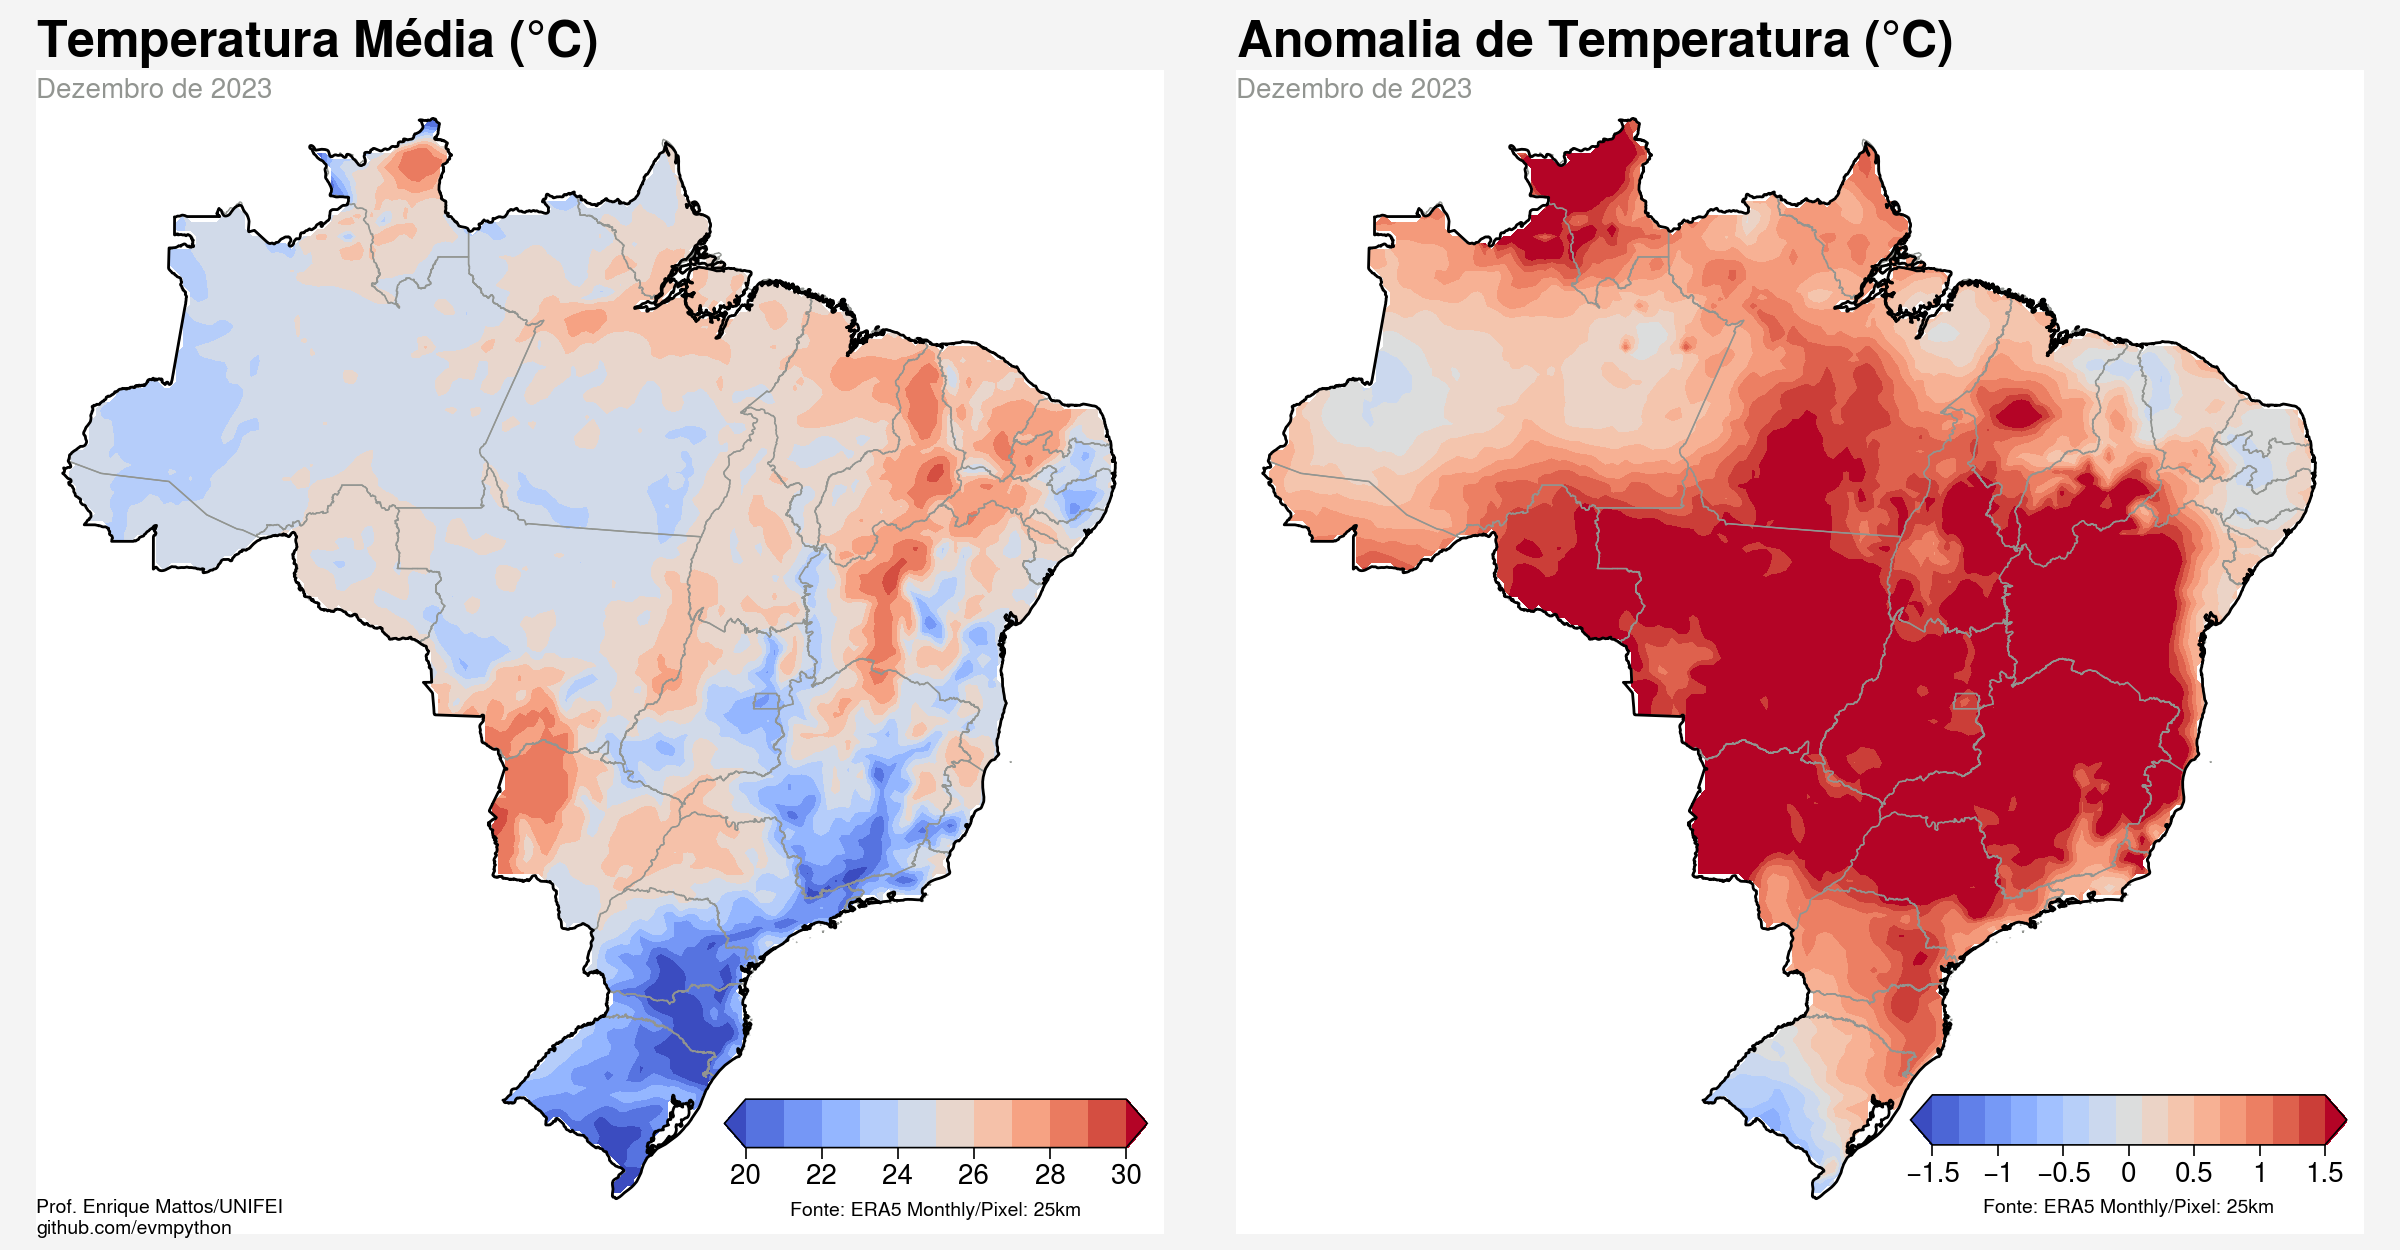

In [26]:
%%time

# cria a moldura da figura
fig, ax = pplt.subplots(axwidth=6, ncols=2, nrows=1, tight=True, proj='pcarree')

# define formato da figura
ax.format(coast=False, borders=False, innerborders=False,
          labels=False, latlines=5, lonlines=10,
          latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
          small='20px', large='25px',
          linewidth=0, grid=False)

# plota subtítulo
ax.text(lonmin, latmax-1.0, f'{nome_mes[int(mes)-1]} de {ano}', color='grey', fontsize=10)

#--------------------------------------------------------------#
#                            FIG-1
#--------------------------------------------------------------#
# plota mapa
map1 = ax[0].contourf(t2m_mensal_brasil['lon'],
                      t2m_mensal_brasil['lat'],
                      t2m_mensal_brasil.loc[f'{ano}-{mes}-01'].salem.roi(shape=shapefile_brasil),
                      cmap='coolwarm',
                      vmin=20, vmax=30,
                      levels=pplt.arange(20, 30, 1),
                      extend='both',
                      colorbar='best',
                      colorbar_kw={'label': 'Fonte: ERA5 Monthly/Pixel: 25km',
                                   'length': 18,
                                   'frameon': False,
                                   'ticklabelsize': 10,
                                   'labelsize': 7,
                                   'width': 2,
                                   'ticks': 2})

# título da figura
ax[0].format(title=f'Temperatura Média ($\degree$C)',
          titleloc='l',
          titleweight='bold',
          titlecolor='black')

# plota contorno dos Estados
estados_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/estados_do_brasil/BR_UF_2019.shp')
estados_brasil.plot(edgecolor='gray', facecolor='none', linewidth=0.5, alpha=1, ax=ax[0])

# plota contorno do Brasil
contorno_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/brasil/BRAZIL.shp')
contorno_brasil.plot(edgecolor='black', facecolor='none', linewidth=1.0, alpha=1, ax=ax[0])

# informação na figura
ax[0].annotate('Prof. Enrique Mattos/UNIFEI\ngithub.com/evmpython', xy=(lonmin,latmin), fontsize=7, color='black')

#--------------------------------------------------------------#
#                            FIG-2
#--------------------------------------------------------------#
ax[1].contourf(anomalia['lon'],
               anomalia['lat'],
               anomalia[0,:,:],
               cmap='coolwarm',
               vmin=-1.5, vmax=1.5,
               levels=pplt.arange(-1.5, 1.5, 0.2),
               extend='both',
               colorbar='best',
               colorbar_kw={'label': 'Fonte: ERA5 Monthly/Pixel: 25km',
                            'length': 18,
                            'frameon': False,
                            'ticklabelsize': 10,
                            'labelsize': 7,
                            'width': 2,
                            'ticks': 0.5})

# título da figura
ax[1].format(title=f'Anomalia de Temperatura ($\degree$C)',
          titleloc='l',
          titleweight='bold',
          titlecolor='black')

# plota contorno dos Estados
estados_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/estados_do_brasil/BR_UF_2019.shp')
estados_brasil.plot(edgecolor='gray', facecolor='none', linewidth=0.5, alpha=1, ax=ax[1])

# plota contorno do Brasil
contorno_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/brasil/BRAZIL.shp')
contorno_brasil.plot(edgecolor='black', facecolor='none', linewidth=1.0, alpha=1, ax=ax[1])

# salva figura
fig.save(f'Fig_2_ERA5_t2m_temperatura_e_anomalia_{ano}_{mes}.png', dpi=300)

# **PARTE 4)**:  MAPA DE `ANOMALIA` PARA DOIS MESES DIFERENTES

In [27]:
%%time
#========================================================================#
#                         LEITURA DOS DADOS
#========================================================================#
# nome do mês
nome_mes =  ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']

# limites do Brasil
lonmin, lonmax, latmin, latmax = -75.0, -33.0, -35.0, 7.0

# link dos dados
url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/Reanalysis_Data/'

# carrega os dados
t2m_mensal = xr.open_dataset(url + 'ERA5/monthly_2d/Surface')

# transforma as longitudes de 0/360 para -180/+180
t2m_mensal.coords['lon'] = ((t2m_mensal.coords['lon'] + 180) % 360) - 180
t2m_mensal = t2m_mensal.sortby(t2m_mensal.lon)

# seleciona os dados para o Brasil
t2m_mensal_brasil = t2m_mensal.sel(lon=slice(lonmin,lonmax), lat=slice(latmin,latmax)) #.sel(time=slice('1990-01-01','2024-12-01'))

#========================================================================#
#                         CALCULA ANOMALIA
#========================================================================#
# leitura do shapefile do Brasil
shapefile_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/brasil/BRAZIL.shp')

# transforma de Kelvim para Celsius
t2m_mensal_brasil = t2m_mensal_brasil['t2m'] - 275.15

# calculando a CLIMATOLOGIA
climatologia = t2m_mensal_brasil.sel(time=slice('1990-01-01','2020-12-31')).groupby("time.month").mean("time")

# calculando a ANOMALIA
ano1, mes1 = '2022', '12'
ano2, mes2 = '2023', '12'

anomalia1 = t2m_mensal_brasil.sel(time=slice(f'{ano1}-{mes1}',f'{ano1}-{mes1}')).groupby("time.month") - climatologia
anomalia2 = t2m_mensal_brasil.sel(time=slice(f'{ano2}-{mes2}',f'{ano2}-{mes2}')).groupby("time.month") - climatologia

# recorta o dado para região
anomalia1 = anomalia1.salem.roi(shape=shapefile_brasil)
anomalia2 = anomalia2.salem.roi(shape=shapefile_brasil)

CPU times: user 2.69 s, sys: 509 ms, total: 3.2 s
Wall time: 26.9 s


In [28]:
# mostra os dados
anomalia1

<xarray.DataArray 't2m' (time: 1, lat: 169, lon: 169)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2022-12-01
  * lat      (lat) float64 -35.0 -34.75 -34.5 -34.25 -34.0 ... 6.25 6.5 6.75 7.0
  * lon      (lon) float64 -75.0 -74.75 -74.5 -74.25 ... -33.5 -33.25 -33.0
    month    (time) int64 12
Attributes:
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

In [29]:
# mostra os dados
anomalia2

<xarray.DataArray 't2m' (time: 1, lat: 169, lon: 169)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2023-12-01
  * lat      (lat) float64 -35.0 -34.75 -34.5 -34.25 -34.0 ... 6.25 6.5 6.75 7.0
  * lon      (lon) float64 -75.0 -74.75 -74.5 -74.25 ... -33.5 -33.25 -33.0
    month    (time) int64 12
Attributes:
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

CPU times: user 12.8 s, sys: 1.6 s, total: 14.4 s
Wall time: 13.4 s


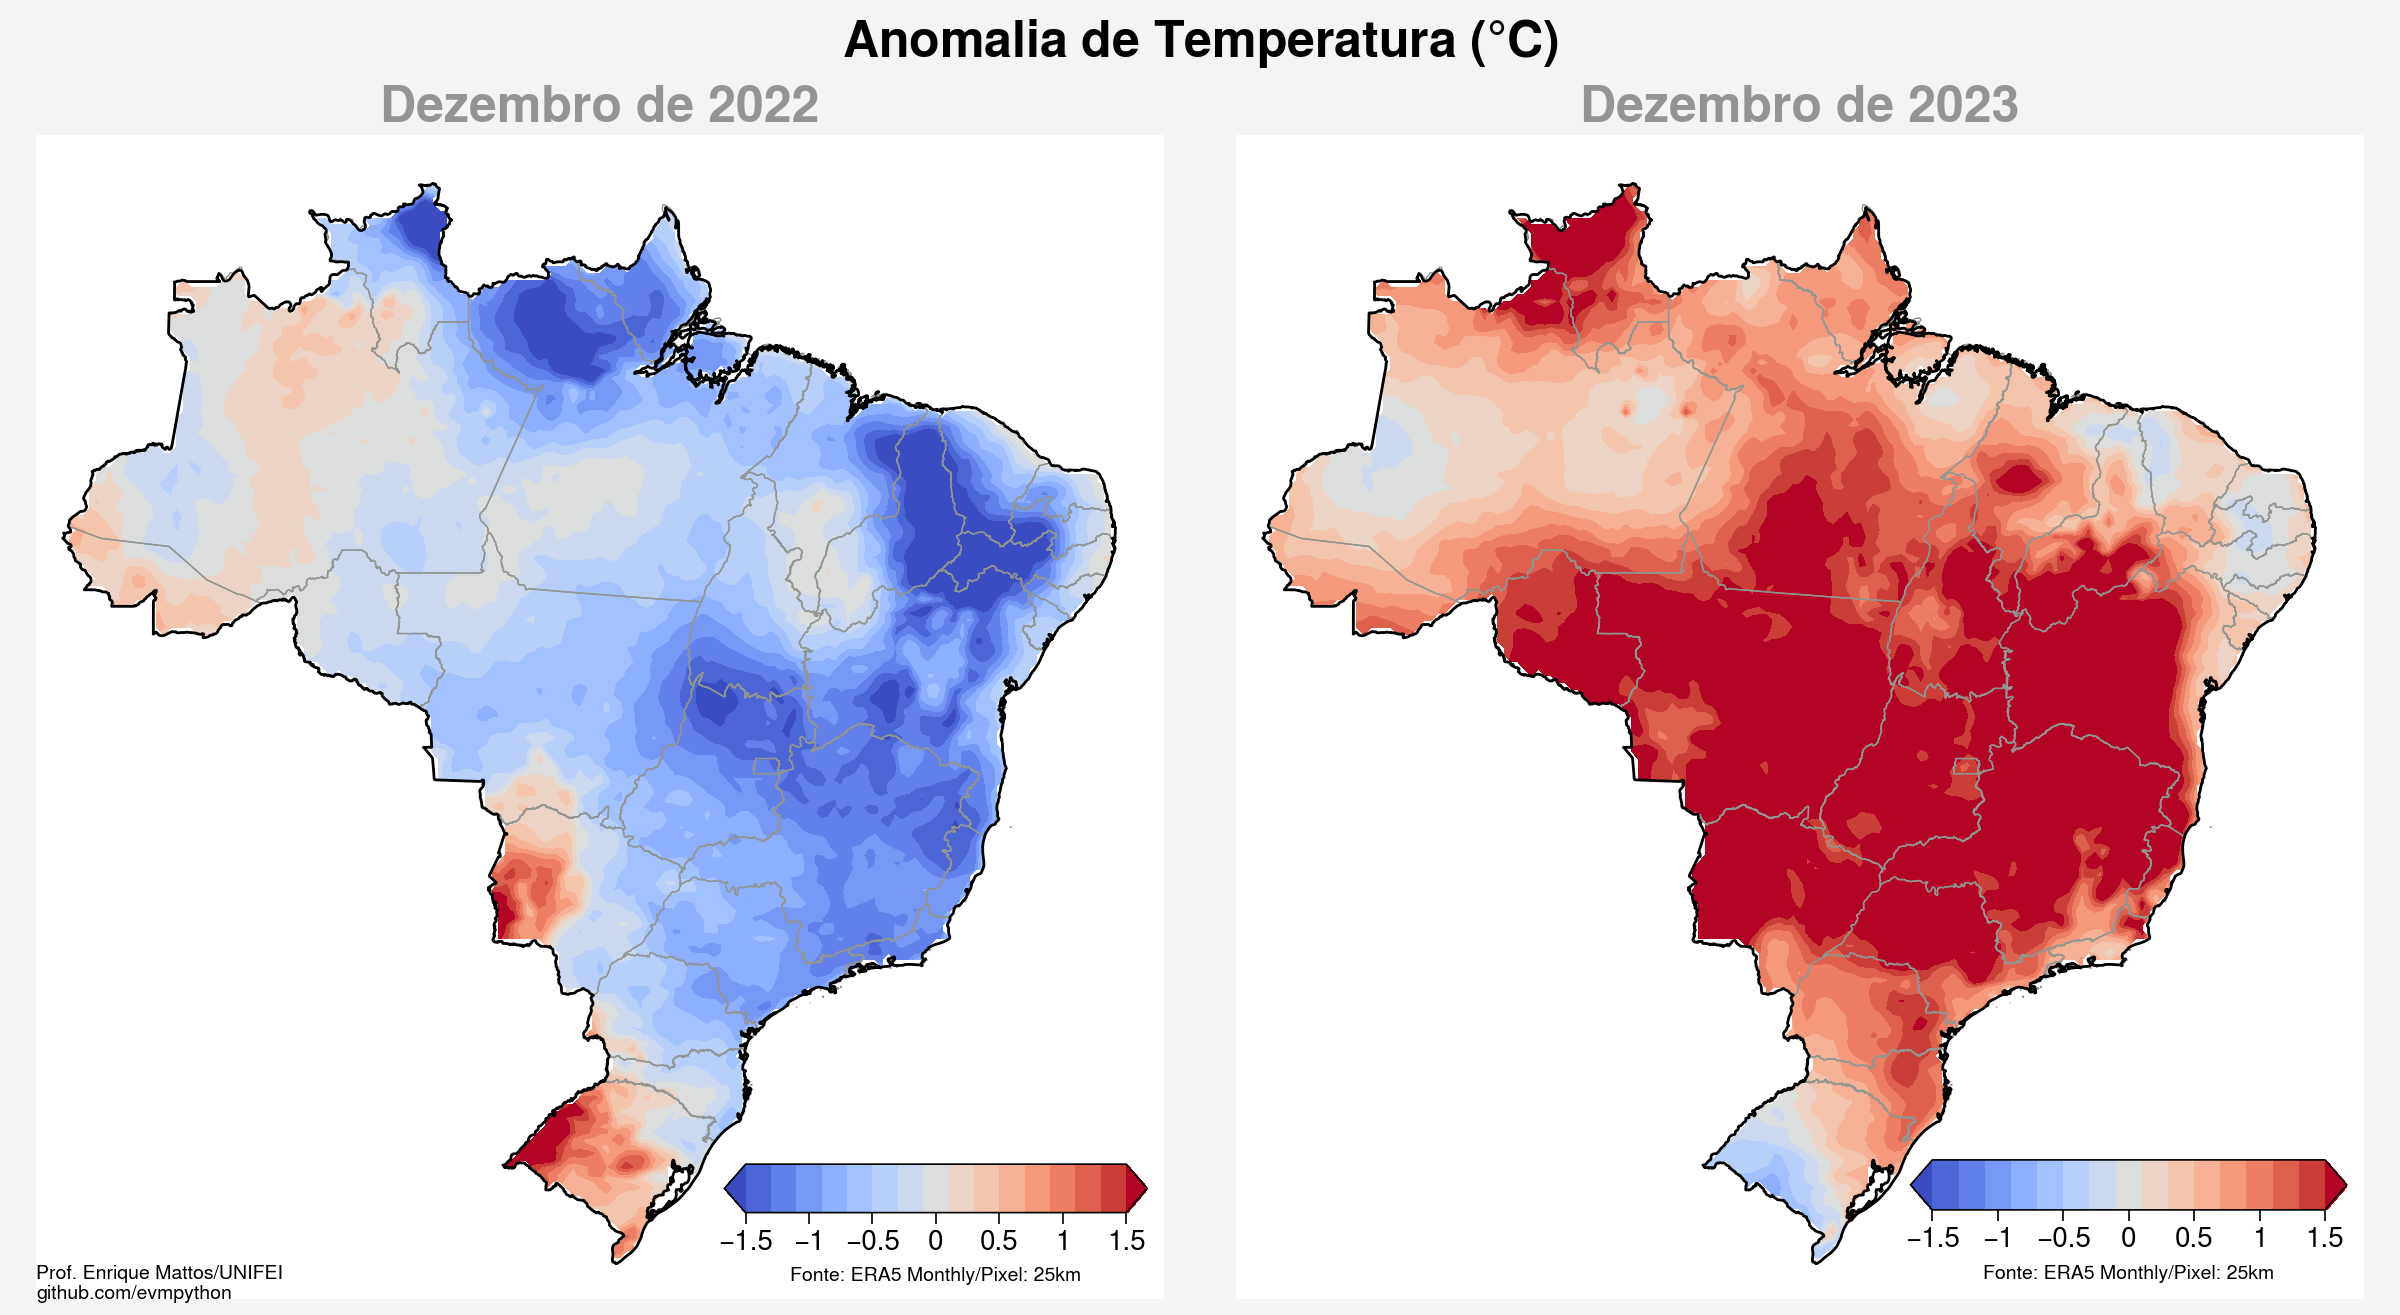

In [30]:
%%time

# cria a moldura da figura
fig, ax = pplt.subplots(axwidth=6, ncols=2, nrows=1, tight=True, proj='pcarree')

# define formato da figura
ax.format(coast=False, borders=False, innerborders=False,
          labels=False, latlines=5, lonlines=10,
          latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
          small='20px', large='25px',
          linewidth=0, grid=False,
          suptitle=f'Anomalia de Temperatura ($\degree$C)')

#--------------------------------------------------------------#
#                            FIG-1
#--------------------------------------------------------------#
# plota mapa
map1 = ax[0].contourf(anomalia1['lon'],
                      anomalia1['lat'],
                      anomalia1[0,:,:],
                      cmap='coolwarm',
                      vmin=-1.5, vmax=1.5,
                      levels=pplt.arange(-1.5, 1.5, 0.2),
                      extend='both',
                      colorbar='best',
                      colorbar_kw={'label': 'Fonte: ERA5 Monthly/Pixel: 25km',
                                   'length': 18,
                                   'frameon': False,
                                   'ticklabelsize': 10,
                                   'labelsize': 7,
                                   'width': 2,
                                   'ticks': 0.5})

# título da figura
ax[0].format(title=f'{nome_mes[int(mes1)-1]} de {ano1}',
             titleloc='c',
             titleweight='bold',
             titlecolor='grey')

# plota contorno dos Estados
estados_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/estados_do_brasil/BR_UF_2019.shp')
estados_brasil.plot(edgecolor='gray', facecolor='none', linewidth=0.5, alpha=1, ax=ax[0])

# plota contorno do Brasil
contorno_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/brasil/BRAZIL.shp')
contorno_brasil.plot(edgecolor='black', facecolor='none', linewidth=1.0, alpha=1, ax=ax[0])

# informação na figura
ax[0].annotate('Prof. Enrique Mattos/UNIFEI\ngithub.com/evmpython', xy=(lonmin,latmin), fontsize=7, color='black')

#--------------------------------------------------------------#
#                            FIG-2
#--------------------------------------------------------------#
ax[1].contourf(anomalia2['lon'],
               anomalia2['lat'],
               anomalia2[0,:,:],
               cmap='coolwarm',
               vmin=-1.5, vmax=1.5,
               levels=pplt.arange(-1.5, 1.5, 0.2),
               extend='both',
               colorbar='best',
               colorbar_kw={'label': 'Fonte: ERA5 Monthly/Pixel: 25km',
                            'length': 18,
                            'frameon': False,
                            'ticklabelsize': 10,
                            'labelsize': 7,
                            'width': 2,
                            'ticks': 0.5})

# título da figura
ax[1].format(title=f'{nome_mes[int(mes2)-1]} de {ano2}',
             titleloc='c',
             titleweight='bold',
             titlecolor='grey')

# plota contorno dos Estados
estados_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/estados_do_brasil/BR_UF_2019.shp')
estados_brasil.plot(edgecolor='gray', facecolor='none', linewidth=0.5, alpha=1, ax=ax[1])

# plota contorno do Brasil
contorno_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/brasil/BRAZIL.shp')
contorno_brasil.plot(edgecolor='black', facecolor='none', linewidth=1.0, alpha=1, ax=ax[1])

# salva figura
fig.save(f'Fig_3_ERA5_t2m_anomalia_{ano1}{mes1}_{ano2}{mes2}.png', dpi=300)